In [19]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [20]:
import os

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    os.chdir('TFMDS')
else:
    # En VS Code local, nos movemos al directorio raíz del proyecto
    # Usa raw string para evitar errores de escape en rutas Windows
    current_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(current_dir)

# OPCIONAL: Para verificar que estás en la ruta correcta y ver las carpetas
print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: C:\Users\jmora\Documents\TFMDS


## Lectura de fichero y adaptación de los tipos


In [21]:
import pandas as pd

# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/STDatosVentasTienda.csv'

# Cargar el archivo en un DataFrame de Pandas
dfSTventas = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'])

# Convertir la columna anio_mes a período mensual
# dfSTventas['anio_mes'] = pd.to_datetime(dfSTventas['anio_mes']).dt.to_period('M')
# Eliminar columna anio_mes
dfSTventas = dfSTventas.drop(columns=['anio_mes'])

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfSTventas.head())

print("\nInformación de las columnas y tipos de datos:")
dfSTventas.info()

Primeras filas del DataFrame:
  idSecuencia  producto  udsVenta  bolPromocion  bolOpen  bolHoliday  \
0  2022-11-06         1         0             1        0           1   
1  2022-11-07         1        12             1        1           0   
2  2022-11-08         1        28             1        1           0   
3  2022-11-09         1        14             1        1           0   
4  2022-11-10         1        26             1        1           0   

   udsStock  rotura_stock  
0       148         False  
1       148         False  
2       136         False  
3       306         False  
4       291         False  

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   idSecuencia   653514 non-null  datetime64[ns]
 1   producto      653514 non-null  int64         
 2   uds

# Fijar datos erróneos
Se ha visto que los días que la tienda está cerrada existen algunos datos con ventas. Se procede a poner a cero las ventas en los días qn que la tienda está cerrada

In [22]:
# Poner a cero udsVenta en días que la tienda está cerrada
dfSTventas.loc[dfSTventas['bolOpen'] == 0, 'udsVenta'] = 0
print("\nNúmero de días con ventas cero:", (dfSTventas['udsVenta'] == 0).sum())


Número de días con ventas cero: 417485


# Incluir características de calendario
- Día de la semana
- Mes
- Trimestre
- Si es fin de semana. En este caso ya está representado por día de la semana

In [23]:
# Incluir en dfSTventas nuevas columnas de características temporales
dfSTventas['dia_semana'] = dfSTventas['idSecuencia'].dt.dayofweek
dfSTventas['mes'] = dfSTventas['idSecuencia'].dt.month
dfSTventas['trimestre'] = dfSTventas['idSecuencia'].dt.quarter
# dfSTventas['fin_de_semana'] = dfSTventas['dia_semana'].isin([5, 6]).astype(int)
print("\nDataFrame con nuevas características temporales:")
print(dfSTventas.head())


DataFrame con nuevas características temporales:
  idSecuencia  producto  udsVenta  bolPromocion  bolOpen  bolHoliday  \
0  2022-11-06         1         0             1        0           1   
1  2022-11-07         1        12             1        1           0   
2  2022-11-08         1        28             1        1           0   
3  2022-11-09         1        14             1        1           0   
4  2022-11-10         1        26             1        1           0   

   udsStock  rotura_stock  dia_semana  mes  trimestre  
0       148         False           6   11          4  
1       148         False           0   11          4  
2       136         False           1   11          4  
3       306         False           2   11          4  
4       291         False           3   11          4  


# Time elapsed
No aporta poner una columna con el número de días pasados desde la primera lectura. Tampoco el día del año.

# Incluir Lags
- En la gráfica PAC de ventas diarias acumuladas, se observa una correlación en con los anteriores 7 días. Se pone lag de los siete días anteriores
- Hay que tener en cuenta el producto
- Otras posibilidades:
- - Sería bueno el mismo día de la misma semana del año pasado, pero se elimina un año entero de datos

In [24]:
# 1. Asegurarnos de que el DataFrame esté ordenado
dfSTventas = dfSTventas.sort_values(by=['producto', 'idSecuencia']).reset_index(drop=True)

# 2. Crear un DataFrame temporal SOLO con los días abiertos
# Al eliminar las filas con bolOpen == 0, "conectamos" los días abiertos secuencialmente
df_open = dfSTventas[dfSTventas['bolOpen'] == 1].copy()

# 3. Calcular los 7 lags sobre este subconjunto
# Agrupamos por producto para que el lag no mezcle datos de diferentes productos
for i in range(1, 8):
    col_name = f'lag_ventas_{i}'
    df_open[col_name] = df_open.groupby('producto')['udsVenta'].shift(i)

# 4. Unir los lags calculados al DataFrame original
# Usamos el índice para asegurar que cada lag vuelva a su fila original correcta
cols_lags = [f'lag_ventas_{i}' for i in range(1, 8)]
dfSTventas = dfSTventas.join(df_open[cols_lags])

# 5. Propagar valores hacia adelante para días cerrados (forward fill)
# Esto rellena los NaN de días cerrados con el último valor conocido
dfSTventas[cols_lags] = dfSTventas.groupby('producto')[cols_lags].ffill()

# 6. Rellenar primeros registros (que aún tienen NaN) con 0
dfSTventas[cols_lags] = dfSTventas[cols_lags].fillna(0)

# Rolling window aggregations
- Se calcula la media de los 30 días anteriores

Posibles
- Media, máximo, mínimo, desviación estándard de ventas del mes pasado o mismo mes año pasado (si no hay datos qué hacer?) para el mismo producto
- Lo mismo para ventas totales de los productos del mismo cluster?
- Lo mismo para ventas totales de todos los producto=?
- alternativas varios valores seguidos, se pued poner varios y solapados (ver Figura6.3 Capítulo 6 Modern Time Series)- 

In [25]:
# Calcular la media móvil del mes anterior (aprox 30 días)
dfSTventas['media_mes_anterior'] = (
    dfSTventas.groupby('producto')['udsVenta']
    .shift(1)                           # Desplazamos 1 día para NO incluir la venta de hoy
    .rolling(window=30, min_periods=1)  # Ventana de 30 días naturales
    .mean()                             # Calcular la media
)

# Seasonal rolling window aggregations

Fuera de la semana no se han observado periodos estaciones claros

# Exponentially weighted moving average (EWMA)

Se calcula un promedio en la que los valores recientes tienen un peso mayor que los valores pasados.
Un técnica es calcular el EWNA a corto plazo (3 a 7 días) y a largo plazo (28 a 90 días), y con la diferencia se representa la tendencia de ventas del producto

In [26]:
# EWMA de la última semana operativa (span=7)
dfSTventas['EWMA_corto'] = dfSTventas.groupby('producto')['udsVenta'].ewm(span=7).mean().reset_index(drop=True).shift(1)
# EWMA del último mes (span=28)
dfSTventas['EWMA_largo'] = dfSTventas.groupby('producto')['udsVenta'].ewm(span=28).mean().reset_index(drop=True).shift(1)
# Característica de tendencia/aceleración
dfSTventas['Tendencia_EWMA'] = dfSTventas['EWMA_corto'] - dfSTventas['EWMA_largo']

# Cluster de productos según volumen de ventas

## Análisis para determinar número de clsuters

In [27]:
# Número de productos únicos
dfSTventasPorProducto = (dfSTventas.groupby('producto').agg({'udsVenta': 'sum'}).sort_values('udsVenta', ascending=False).reset_index())
# describe dfSTventasPorProducto
print("\nDescripción de unidades vendidas por producto:")
print(dfSTventasPorProducto.udsVenta.describe())


Descripción de unidades vendidas por producto:
count     894.000000
mean     1050.398210
std       743.498502
min       104.000000
25%       572.250000
50%       843.500000
75%      1295.000000
max      6391.000000
Name: udsVenta, dtype: float64


In [28]:
# Crear N clusters de productos según sus ventas totales
from sklearn.cluster import KMeans

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(dfSTventasPorProducto[['udsVenta']])
dfSTventasPorProducto['Cluster'] = kmeans.labels_

# mostrar cuantos productos tiene cada cluster
print("\nNúmero de productos por cluster:")
print(dfSTventasPorProducto['Cluster'].value_counts())

# mostrar cuantas ventas totales tiene cada cluster
print("\nVentas totales por cluster:")
print(dfSTventasPorProducto.groupby('Cluster')['udsVenta'].sum())


Número de productos por cluster:
Cluster
3    471
0    301
1    106
2     16
Name: count, dtype: int64

Ventas totales por cluster:
Cluster
0    360977
1    244387
2     65455
3    268237
Name: udsVenta, dtype: int64


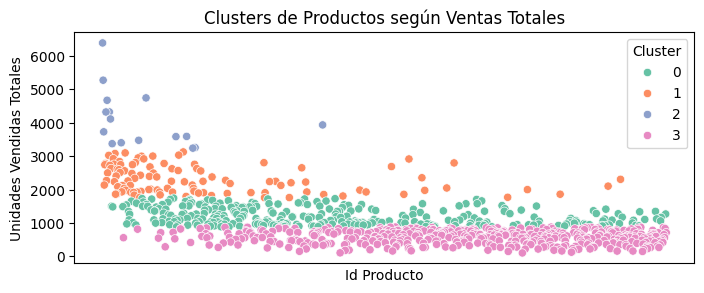

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar gráfico de los clusters
plt.figure(figsize=(8, 3))
sns.scatterplot(data=dfSTventasPorProducto, x='producto', y='udsVenta', hue='Cluster', palette='Set2', legend='full')
plt.title('Clusters de Productos según Ventas Totales')
plt.xticks([])
plt.xlabel('Id Producto')
plt.ylabel('Unidades Vendidas Totales')
plt.legend(title='Cluster')
plt.show()

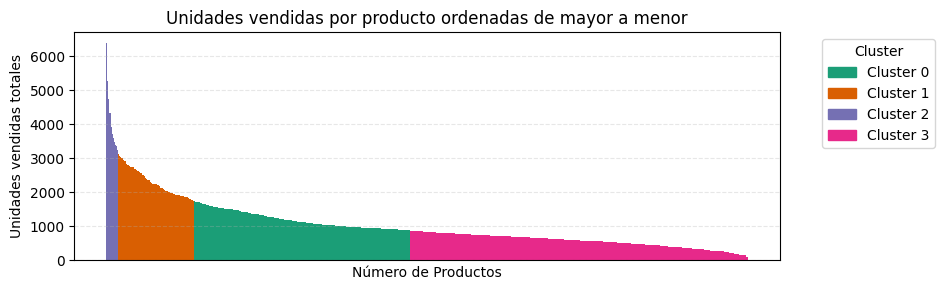

In [30]:
# Paleta de colores para los 4 clusters

cluster_colors = {
    0: '#1b9e77',  # verde azulado
    1: '#d95f02',  # naranja
    2: '#7570b3',  # azul
    3: '#e7298a'   # rosa
}

# Asignamos colores según el cluster
colors = dfSTventasPorProducto['Cluster'].map(cluster_colors)

plt.figure(figsize=(8, 3))
plt.bar(range(len(dfSTventasPorProducto)),
        dfSTventasPorProducto['udsVenta'],
        width=1.0,
        color=colors,
        edgecolor='none')

plt.title('Unidades vendidas por producto ordenadas de mayor a menor', fontsize=12)
plt.xlabel('Número de Productos')
plt.ylabel('Unidades vendidas totales')
plt.xticks([])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Leyenda para los clusters
handles = [plt.Rectangle((0,0),1,1, color=cluster_colors[c]) for c in cluster_colors]
plt.legend(handles, [f'Cluster {c}' for c in cluster_colors], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Incorporar clusters al dataframe

In [31]:
# incorporar los clusters al DataFrame original
dfSTventas = dfSTventas.merge(dfSTventasPorProducto[['producto', 'Cluster']], on='producto', how='left')


Gráfica de tiempo para cada cluster

In [32]:
# Crear dataframe por cluster idSecuencia y suma de udsVenta
dfSTventasPorCluster = (dfSTventas[dfSTventas.bolOpen!=0].groupby(['idSecuencia', 'Cluster'])
                        .agg({'udsVenta': 'sum', 'bolOpen': 'max'})
                        .reset_index())
print("\nDataFrame de ventas por idSecuencia y Cluster:")
print(dfSTventasPorCluster.head())



DataFrame de ventas por idSecuencia y Cluster:
  idSecuencia  Cluster  udsVenta  bolOpen
0  2022-11-07        0       714        1
1  2022-11-07        1       452        1
2  2022-11-07        2        91        1
3  2022-11-07        3       618        1
4  2022-11-08        0       682        1


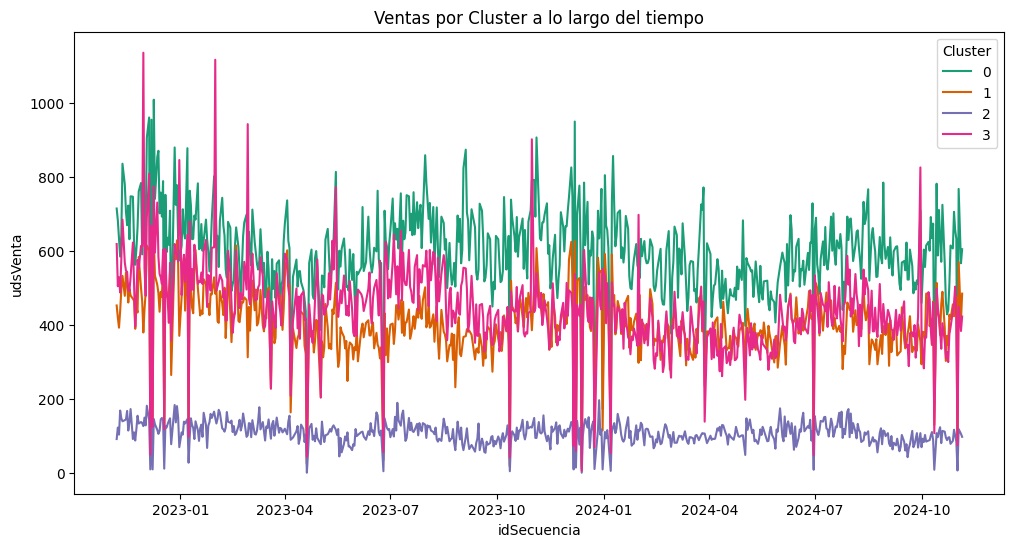

In [33]:
# Mostrar gráfico de ventas por cluster a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfSTventasPorCluster, x='idSecuencia', y='udsVenta', hue='Cluster', palette=cluster_colors)
plt.title('Ventas por Cluster a lo largo del tiempo')
plt.show()


# Crear datos de entrenamiento y de test
A partir de aquí se van a generar campos que conviene calcularlos en el juego de entrenamiento y después informalos en el de test para evitar data leakage

In [34]:
# Crear df_train y df_test a partir de dfVentas teniendo en cuanta los días de corte
numDias = 30  # Días más recientes para test

# Obtener la fecha máxima
fecha_maxima = dfSTventas['idSecuencia'].max()
print(f"Fecha máxima en el dataset: {fecha_maxima}")

# Calcular fecha de corte
fecha_corte = fecha_maxima - pd.Timedelta(days=numDias)
print(f"Fecha de corte (últimos {numDias} días): {fecha_corte}")

# Dividir en train y test
df_train = dfSTventas[dfSTventas['idSecuencia'] < fecha_corte].copy()
df_test = dfSTventas[dfSTventas['idSecuencia'] >= fecha_corte].copy()

print(f"\nRegistros en train: {len(df_train):,}")
print(f"Registros en test: {len(df_test):,}")
print(f"Fechas train: {df_train['idSecuencia'].min()} a {df_train['idSecuencia'].max()}")
print(f"Fechas test: {df_test['idSecuencia'].min()} a {df_test['idSecuencia'].max()}")


Fecha máxima en el dataset: 2024-11-05 00:00:00
Fecha de corte (últimos 30 días): 2024-10-06 00:00:00

Registros en train: 625,800
Registros en test: 27,714
Fechas train: 2022-11-06 00:00:00 a 2024-10-05 00:00:00
Fechas test: 2024-10-06 00:00:00 a 2024-11-05 00:00:00

Registros en train: 625,800
Registros en test: 27,714
Fechas train: 2022-11-06 00:00:00 a 2024-10-05 00:00:00
Fechas test: 2024-10-06 00:00:00 a 2024-11-05 00:00:00


# Encoding del producto
Preparar encoding del código del producto para los algoritmos de árboles

In [35]:
# ============================================================
# TARGET ENCODING (Para cuando tienes muchos productos)
# ============================================================
# Calcular la media de udsVenta por producto usando solo el conjunto de entrenamiento
target_encoding = df_train.groupby('producto')['udsVenta'].mean().to_dict()

# Aplicar el encoding a train y test
df_train['producto_encoded'] = df_train['producto'].map(target_encoding)
df_test['producto_encoded'] = df_test['producto'].map(target_encoding)

print(f"\nTarget Encoding aplicado:")
print(f"Productos únicos: {df_train['producto'].nunique()}")
print(f"Ejemplo de mapping (primeros 5 productos):")
print({k: f"{v:.2f}" for k, v in list(target_encoding.items())[:5]})


Target Encoding aplicado:
Productos únicos: 894
Ejemplo de mapping (primeros 5 productos):
{1: '8.69', 2: '7.30', 3: '5.09', 4: '2.97', 5: '3.83'}


# Salvar fichero

In [37]:
# salvar como fichero los dataframe de test y train, guardarlos enun dataframe pero marcando los que son de train y de test

# GUARDAR EN PICKLE

print("\n=== GUARDANDO ARCHIVOS  ===")
# Guardar con 4 decimales
df_train.to_csv('datos/df_train.csv', sep=';', index=False, float_format='%.4f')
df_test.to_csv('datos/df_test.csv', sep=';', index=False, float_format='%.4f')


=== GUARDANDO ARCHIVOS  ===
